In [92]:
import nbimporter # to import methods from another notebook
import manta_file_processing as mfp
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import time
import random
import os

In [80]:
heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")

In [93]:
from importlib import reload
reload(mfp)

Importing Jupyter notebook from manta_file_processing.ipynb


<module 'manta_file_processing' from 'manta_file_processing.ipynb'>

In [88]:
if os.name=="nt":
    folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some"
else:
    folder="/tf/notebooks/data/0_manta_selected_annotated_some"
print("os = "+os.name)
print(folder+"\n ---")
dataset=mfp.get_manta_files(folder=folder)

os = posix
/tf/notebooks/data/0_manta_selected_annotated_some
 ---
total:1801
labelled:295


In [89]:
df=dataset[dataset.body_landmark_path.isnull()==False].sample(frac=1)
manta_data=np.array(df[["image_path","body_landmark_path"]])
#data=np.array([df.image_path,df.body_landmark_path])
manta_data.shape

(295, 2)

In [90]:
image_size=[100,100]
heatmap_size=[17,17]

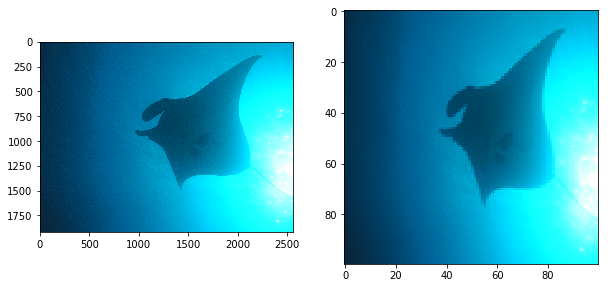

In [112]:
im_path,blm_path = manta_data[3]
image = Image.open(im_path)
body_landmarks=mfp.extract_body_landmarks(blm_path)
heatmaps=mfp.gen_heatmaps(body_landmarks,image_size)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 10))
axes[0].imshow(image)

image=mfp.denormalize(mfp.image_to_numpy(image,image_size))
axes[1].imshow(image)    
#axes[2].imshow(image[:,::-1])   
plt.show()


In [95]:
mfp.apply_heatmaps(image,heatmaps)

TypeError: 'tuple' object cannot be interpreted as an integer

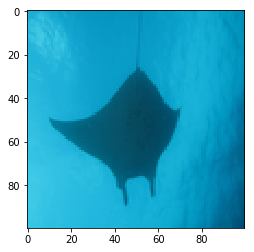

In [61]:
plt.imshow(image)

In [62]:
image.shape

(100, 100, 3)

In [45]:
flip_hm=heatmaps[::-1]

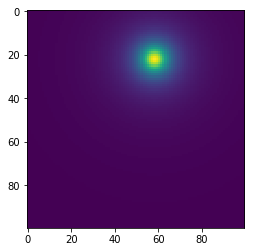

In [63]:
plt.imshow(flip_hm[:,:,0])

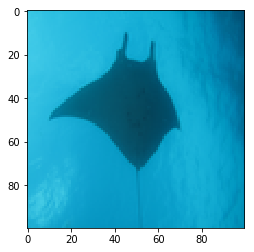

In [68]:
flip_img=image[::-1]
plt.imshow(flip_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


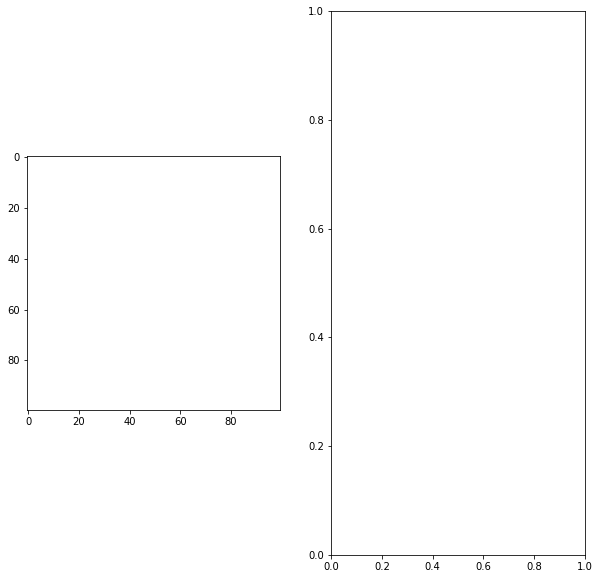

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 10))
axes[0].imshow((image))
#axes[1].imshow(heatmaps[:,:,4])
plt.show()

In [74]:
def flip_image(image,heatmaps):
    flip_image=image[::-1,]
    flip_heatmap=heatmaps[::-1,]
    return flip_image,flip_heatmap

In [100]:
X=[]
y=[]
i=0
print ("total:" + str(manta_data.shape[0]))

for im_path,blm_path in manta_data[:5]:
    try:
        image = Image.open(im_path)
        body_landmarks=mfp.extract_body_landmarks(blm_path)
    except:
        print(" \n Error on "+blm_path)
        
    image=mfp.image_to_numpy(image,image_size)
    numpy_heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size=heatmap_size)
    #numpy_heatmaps=mfp.heatmaps_to_numpy(heatmaps)
    
    if image.shape[2]>3:
        print("\n More then 3 channels")
        print(blm_path)
        numpy_heatmaps=None
    
    if numpy_heatmaps is not None and numpy_heatmaps.sum()>0:
        y.append(numpy_heatmaps[:,:,4:])
        X.append(image) 
        #flip_img, flip_hm=flip_image(image,heatmaps)
        #y.append(flip_hm[:,:,4:])
        #X.append(flip_img) 
        
    print(i,end=" ")
    i+=1

X=np.array(X)
y=np.array(y)
print("\n====================")
print("Done.\nX.shape="+str(X.shape))
print("y.shape="+str(y.shape))


total:295
0 1 2 3 4 
Done.
X.shape=(5, 100, 100, 3)
y.shape=(5, 17, 17, 1)


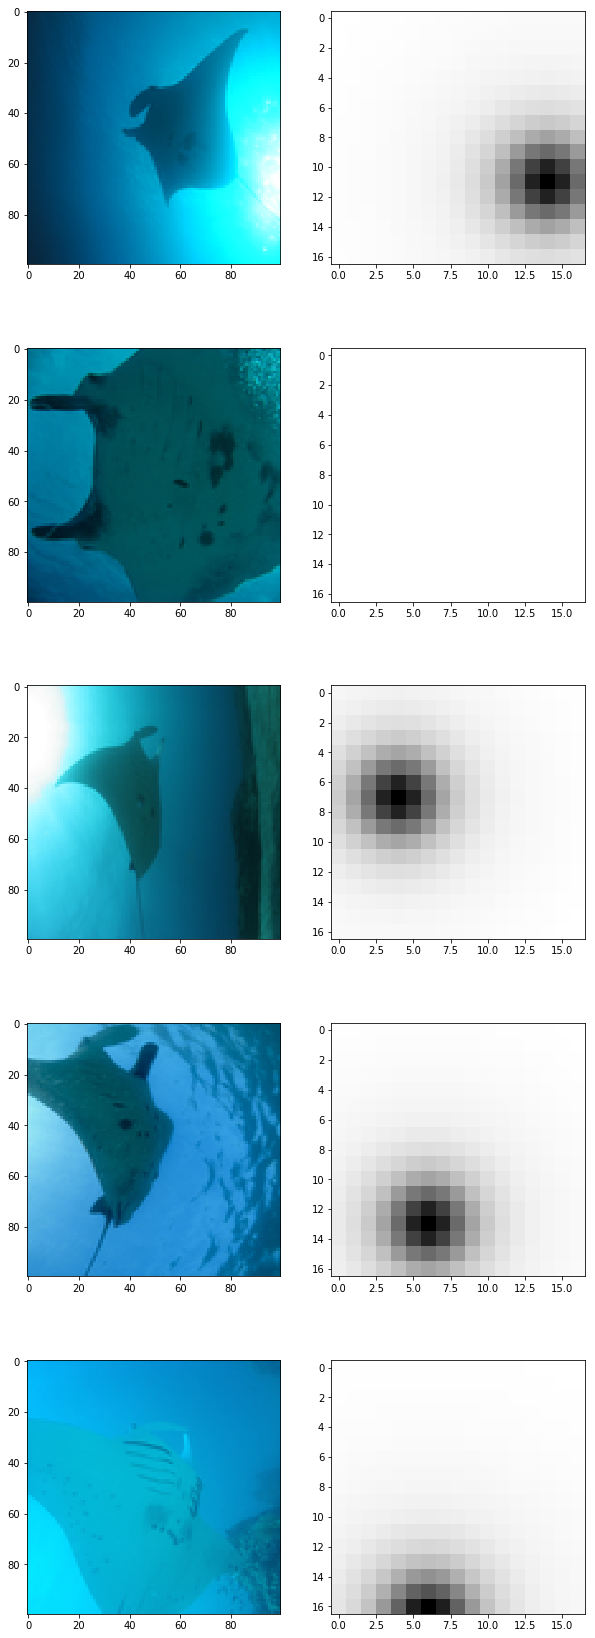

In [102]:
n=5
samples=random.sample(list(np.arange(X.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=2,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X[s]))
    axes[i,1].imshow(y[s][:,:,0],cmap='Greys')
plt.show()


In [10]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense,Conv2DTranspose
from tensorflow.python.keras.layers import BatchNormalization,AveragePooling2D,Activation

from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam

In [11]:
import copy
input_shape=copy.copy(image_size)
input_shape.append(3)
batch_size=8
nb_train_samples=int(round(X.shape[0]*0.95,0))
X_train=X[:nb_train_samples]
X_test =X[nb_train_samples:]
y_train=y[:nb_train_samples]
y_test =y[nb_train_samples:]

In [12]:
#pip install h5py
#pip install cython
#restart jupyther
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
vgg16_net.trainable = False
vgg16_net.summary()

#from tensorflow.keras.models import Model
#mymodel = Model(vgg16_net.get_input_at(0), vgg16_net.layers[n_layer].get_output_at(0))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
bloc

In [13]:
model=Sequential()
model.add(vgg16_net)

model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=32,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=1,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
batch_normalization_v1 (Batc (None, 3, 3, 512)         2048      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          294976    
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 15, 15, 32)        18464     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 17, 17, 1)         289       
__________

In [14]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['binary_accuracy'])

Train on 248 samples, validate on 28 samples
Epoch 1/1200
248/248 [==============================] - 1s 4ms/sample - loss: 16.7045 - binary_accuracy: 0.0685 - val_loss: 14.7363 - val_binary_accuracy: 0.1749
Epoch 2/1200
248/248 [==============================] - 1s 3ms/sample - loss: 16.6331 - binary_accuracy: 0.0685 - val_loss: 14.5709 - val_binary_accuracy: 0.1755
Epoch 3/1200
248/248 [==============================] - 1s 3ms/sample - loss: 16.5635 - binary_accuracy: 0.0685 - val_loss: 14.6824 - val_binary_accuracy: 0.1746
Epoch 4/1200
248/248 [==============================] - 1s 3ms/sample - loss: 16.4964 - binary_accuracy: 0.0685 - val_loss: 14.5016 - val_binary_accuracy: 0.1759
Epoch 5/1200
248/248 [==============================] - 1s 3ms/sample - loss: 16.4339 - binary_accuracy: 0.0685 - val_loss: 14.4881 - val_binary_accuracy: 0.1749
Epoch 6/1200
248/248 [==============================] - 1s 3ms/sample - loss: 16.3498 - binary_accuracy: 0.0685 - val_loss: 14.4305 - val_binary_

248/248 [==============================] - 1s 3ms/sample - loss: 13.6946 - binary_accuracy: 0.0685 - val_loss: 12.2637 - val_binary_accuracy: 0.1781
Epoch 52/1200
248/248 [==============================] - 1s 3ms/sample - loss: 13.6428 - binary_accuracy: 0.0685 - val_loss: 12.1506 - val_binary_accuracy: 0.1782
Epoch 53/1200
248/248 [==============================] - 1s 3ms/sample - loss: 13.5922 - binary_accuracy: 0.0685 - val_loss: 12.2340 - val_binary_accuracy: 0.1781
Epoch 54/1200
248/248 [==============================] - 1s 3ms/sample - loss: 13.5666 - binary_accuracy: 0.0685 - val_loss: 12.0944 - val_binary_accuracy: 0.1784
Epoch 55/1200
248/248 [==============================] - 1s 3ms/sample - loss: 13.5085 - binary_accuracy: 0.0685 - val_loss: 12.1713 - val_binary_accuracy: 0.1783
Epoch 56/1200
248/248 [==============================] - 1s 3ms/sample - loss: 13.4585 - binary_accuracy: 0.0685 - val_loss: 11.9588 - val_binary_accuracy: 0.1784
Epoch 57/1200
248/248 [=============

248/248 [==============================] - 1s 3ms/sample - loss: 11.6846 - binary_accuracy: 0.0685 - val_loss: 10.3334 - val_binary_accuracy: 0.1786
Epoch 102/1200
248/248 [==============================] - 1s 3ms/sample - loss: 11.6509 - binary_accuracy: 0.0685 - val_loss: 10.2749 - val_binary_accuracy: 0.1786
Epoch 103/1200
248/248 [==============================] - 1s 3ms/sample - loss: 11.6234 - binary_accuracy: 0.0685 - val_loss: 10.3448 - val_binary_accuracy: 0.1786
Epoch 104/1200
248/248 [==============================] - 1s 3ms/sample - loss: 11.5833 - binary_accuracy: 0.0685 - val_loss: 10.2505 - val_binary_accuracy: 0.1786
Epoch 105/1200
248/248 [==============================] - 1s 3ms/sample - loss: 11.5471 - binary_accuracy: 0.0685 - val_loss: 10.2909 - val_binary_accuracy: 0.1786
Epoch 106/1200
248/248 [==============================] - 1s 3ms/sample - loss: 11.5208 - binary_accuracy: 0.0685 - val_loss: 10.1968 - val_binary_accuracy: 0.1786
Epoch 107/1200
248/248 [=======

248/248 [==============================] - 1s 3ms/sample - loss: 10.3144 - binary_accuracy: 0.0685 - val_loss: 9.1471 - val_binary_accuracy: 0.1786
Epoch 152/1200
248/248 [==============================] - 1s 3ms/sample - loss: 10.2984 - binary_accuracy: 0.0685 - val_loss: 9.1256 - val_binary_accuracy: 0.1786
Epoch 153/1200
248/248 [==============================] - 1s 3ms/sample - loss: 10.2751 - binary_accuracy: 0.0685 - val_loss: 9.1495 - val_binary_accuracy: 0.1786
Epoch 154/1200
248/248 [==============================] - 1s 3ms/sample - loss: 10.2543 - binary_accuracy: 0.0685 - val_loss: 9.1483 - val_binary_accuracy: 0.1786
Epoch 155/1200
248/248 [==============================] - 1s 3ms/sample - loss: 10.2271 - binary_accuracy: 0.0685 - val_loss: 9.1354 - val_binary_accuracy: 0.1786
Epoch 156/1200
248/248 [==============================] - 1s 3ms/sample - loss: 10.2191 - binary_accuracy: 0.0685 - val_loss: 9.1260 - val_binary_accuracy: 0.1786
Epoch 157/1200
248/248 [=============

248/248 [==============================] - 1s 3ms/sample - loss: 9.3789 - binary_accuracy: 0.0685 - val_loss: 8.3077 - val_binary_accuracy: 0.1786
Epoch 202/1200
248/248 [==============================] - 1s 3ms/sample - loss: 9.3745 - binary_accuracy: 0.0685 - val_loss: 8.3455 - val_binary_accuracy: 0.1786
Epoch 203/1200
248/248 [==============================] - 1s 3ms/sample - loss: 9.3571 - binary_accuracy: 0.0685 - val_loss: 8.3249 - val_binary_accuracy: 0.1786
Epoch 204/1200
248/248 [==============================] - 1s 3ms/sample - loss: 9.3484 - binary_accuracy: 0.0685 - val_loss: 8.2744 - val_binary_accuracy: 0.1786
Epoch 205/1200
248/248 [==============================] - 1s 3ms/sample - loss: 9.3270 - binary_accuracy: 0.0685 - val_loss: 8.2578 - val_binary_accuracy: 0.1786
Epoch 206/1200
248/248 [==============================] - 1s 3ms/sample - loss: 9.3049 - binary_accuracy: 0.0685 - val_loss: 8.2726 - val_binary_accuracy: 0.1786
Epoch 207/1200
248/248 [===================

Epoch 252/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.7483 - binary_accuracy: 0.0685 - val_loss: 7.7790 - val_binary_accuracy: 0.1786
Epoch 253/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.7397 - binary_accuracy: 0.0685 - val_loss: 7.7343 - val_binary_accuracy: 0.1786
Epoch 254/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.7419 - binary_accuracy: 0.0685 - val_loss: 7.7474 - val_binary_accuracy: 0.1786
Epoch 255/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.7276 - binary_accuracy: 0.0685 - val_loss: 7.7498 - val_binary_accuracy: 0.1786
Epoch 256/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.7109 - binary_accuracy: 0.0685 - val_loss: 7.7064 - val_binary_accuracy: 0.1786
Epoch 257/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.7089 - binary_accuracy: 0.0685 - val_loss: 7.7092 - val_binary_accuracy: 0.1786
Epoch 258/1200
248/248 [====

248/248 [==============================] - 1s 3ms/sample - loss: 8.3439 - binary_accuracy: 0.0685 - val_loss: 7.4027 - val_binary_accuracy: 0.1786
Epoch 303/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.3354 - binary_accuracy: 0.0685 - val_loss: 7.4276 - val_binary_accuracy: 0.1786
Epoch 304/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.3219 - binary_accuracy: 0.0685 - val_loss: 7.3584 - val_binary_accuracy: 0.1786
Epoch 305/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.3129 - binary_accuracy: 0.0685 - val_loss: 7.4595 - val_binary_accuracy: 0.1786
Epoch 306/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.3075 - binary_accuracy: 0.0685 - val_loss: 7.4026 - val_binary_accuracy: 0.1786
Epoch 307/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.3195 - binary_accuracy: 0.0685 - val_loss: 7.4870 - val_binary_accuracy: 0.1786
Epoch 308/1200
248/248 [===================

Epoch 353/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.0536 - binary_accuracy: 0.0685 - val_loss: 7.1267 - val_binary_accuracy: 0.1786
Epoch 354/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.0215 - binary_accuracy: 0.0685 - val_loss: 7.1050 - val_binary_accuracy: 0.1786
Epoch 355/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.0267 - binary_accuracy: 0.0685 - val_loss: 7.1125 - val_binary_accuracy: 0.1786
Epoch 356/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.0231 - binary_accuracy: 0.0685 - val_loss: 7.0976 - val_binary_accuracy: 0.1786
Epoch 357/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.0221 - binary_accuracy: 0.0685 - val_loss: 7.1121 - val_binary_accuracy: 0.1786
Epoch 358/1200
248/248 [==============================] - 1s 3ms/sample - loss: 8.0079 - binary_accuracy: 0.0685 - val_loss: 7.0747 - val_binary_accuracy: 0.1786
Epoch 359/1200
248/248 [====

248/248 [==============================] - 1s 3ms/sample - loss: 7.8433 - binary_accuracy: 0.0685 - val_loss: 6.9428 - val_binary_accuracy: 0.1786
Epoch 404/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.8375 - binary_accuracy: 0.0685 - val_loss: 6.9590 - val_binary_accuracy: 0.1786
Epoch 405/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.8404 - binary_accuracy: 0.0685 - val_loss: 6.9399 - val_binary_accuracy: 0.1786
Epoch 406/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.8400 - binary_accuracy: 0.0685 - val_loss: 6.9608 - val_binary_accuracy: 0.1786
Epoch 407/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.8519 - binary_accuracy: 0.0685 - val_loss: 6.9307 - val_binary_accuracy: 0.1786
Epoch 408/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.8337 - binary_accuracy: 0.0685 - val_loss: 6.9340 - val_binary_accuracy: 0.1786
Epoch 409/1200
248/248 [===================

Epoch 454/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.7079 - binary_accuracy: 0.0685 - val_loss: 6.8317 - val_binary_accuracy: 0.1786
Epoch 455/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.7147 - binary_accuracy: 0.0685 - val_loss: 6.8577 - val_binary_accuracy: 0.1786
Epoch 456/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.7005 - binary_accuracy: 0.0685 - val_loss: 6.8461 - val_binary_accuracy: 0.1786
Epoch 457/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.6997 - binary_accuracy: 0.0685 - val_loss: 6.8251 - val_binary_accuracy: 0.1786
Epoch 458/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.7116 - binary_accuracy: 0.0685 - val_loss: 6.8586 - val_binary_accuracy: 0.1786
Epoch 459/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.7050 - binary_accuracy: 0.0685 - val_loss: 6.8409 - val_binary_accuracy: 0.1786
Epoch 460/1200
248/248 [====

248/248 [==============================] - 1s 3ms/sample - loss: 7.5978 - binary_accuracy: 0.0685 - val_loss: 6.7329 - val_binary_accuracy: 0.1786
Epoch 505/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5728 - binary_accuracy: 0.0685 - val_loss: 6.7400 - val_binary_accuracy: 0.1786
Epoch 506/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5943 - binary_accuracy: 0.0685 - val_loss: 6.7338 - val_binary_accuracy: 0.1786
Epoch 507/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5713 - binary_accuracy: 0.0685 - val_loss: 6.7454 - val_binary_accuracy: 0.1786
Epoch 508/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5822 - binary_accuracy: 0.0685 - val_loss: 6.7369 - val_binary_accuracy: 0.1786
Epoch 509/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5703 - binary_accuracy: 0.0685 - val_loss: 6.7309 - val_binary_accuracy: 0.1786
Epoch 510/1200
248/248 [===================

Epoch 555/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5292 - binary_accuracy: 0.0685 - val_loss: 6.6817 - val_binary_accuracy: 0.1786
Epoch 556/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5274 - binary_accuracy: 0.0685 - val_loss: 6.6968 - val_binary_accuracy: 0.1786
Epoch 557/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5278 - binary_accuracy: 0.0685 - val_loss: 6.6828 - val_binary_accuracy: 0.1786
Epoch 558/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5306 - binary_accuracy: 0.0685 - val_loss: 6.6740 - val_binary_accuracy: 0.1786
Epoch 559/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5263 - binary_accuracy: 0.0685 - val_loss: 6.6799 - val_binary_accuracy: 0.1786
Epoch 560/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5205 - binary_accuracy: 0.0685 - val_loss: 6.6829 - val_binary_accuracy: 0.1786
Epoch 561/1200
248/248 [====

248/248 [==============================] - 1s 3ms/sample - loss: 7.4825 - binary_accuracy: 0.0685 - val_loss: 6.6459 - val_binary_accuracy: 0.1786
Epoch 606/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5050 - binary_accuracy: 0.0685 - val_loss: 6.6471 - val_binary_accuracy: 0.1786
Epoch 607/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4875 - binary_accuracy: 0.0685 - val_loss: 6.6394 - val_binary_accuracy: 0.1786
Epoch 608/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4944 - binary_accuracy: 0.0685 - val_loss: 6.6408 - val_binary_accuracy: 0.1786
Epoch 609/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5749 - binary_accuracy: 0.0685 - val_loss: 6.6775 - val_binary_accuracy: 0.1786
Epoch 610/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5018 - binary_accuracy: 0.0685 - val_loss: 6.6658 - val_binary_accuracy: 0.1786
Epoch 611/1200
248/248 [===================

Epoch 656/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4791 - binary_accuracy: 0.0685 - val_loss: 6.6332 - val_binary_accuracy: 0.1786
Epoch 657/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4807 - binary_accuracy: 0.0685 - val_loss: 6.6217 - val_binary_accuracy: 0.1786
Epoch 658/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4785 - binary_accuracy: 0.0685 - val_loss: 6.6319 - val_binary_accuracy: 0.1786
Epoch 659/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5434 - binary_accuracy: 0.0685 - val_loss: 6.6494 - val_binary_accuracy: 0.1786
Epoch 660/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4723 - binary_accuracy: 0.0685 - val_loss: 6.6429 - val_binary_accuracy: 0.1786
Epoch 661/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5169 - binary_accuracy: 0.0685 - val_loss: 6.6472 - val_binary_accuracy: 0.1786
Epoch 662/1200
248/248 [====

248/248 [==============================] - 1s 3ms/sample - loss: 7.4743 - binary_accuracy: 0.0685 - val_loss: 6.6194 - val_binary_accuracy: 0.1786
Epoch 707/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4692 - binary_accuracy: 0.0685 - val_loss: 6.6143 - val_binary_accuracy: 0.1786
Epoch 708/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4601 - binary_accuracy: 0.0685 - val_loss: 6.6193 - val_binary_accuracy: 0.1786
Epoch 709/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4505 - binary_accuracy: 0.0685 - val_loss: 6.6156 - val_binary_accuracy: 0.1786
Epoch 710/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4501 - binary_accuracy: 0.0685 - val_loss: 6.6096 - val_binary_accuracy: 0.1786
Epoch 711/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4884 - binary_accuracy: 0.0685 - val_loss: 6.6181 - val_binary_accuracy: 0.1786
Epoch 712/1200
248/248 [===================

Epoch 757/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.7223 - binary_accuracy: 0.0685 - val_loss: 6.7892 - val_binary_accuracy: 0.1786
Epoch 758/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.6524 - binary_accuracy: 0.0685 - val_loss: 6.8655 - val_binary_accuracy: 0.1786
Epoch 759/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.7471 - binary_accuracy: 0.0685 - val_loss: 7.2806 - val_binary_accuracy: 0.1786
Epoch 760/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.5906 - binary_accuracy: 0.0685 - val_loss: 7.2795 - val_binary_accuracy: 0.1786
Epoch 761/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4621 - binary_accuracy: 0.0685 - val_loss: 7.1378 - val_binary_accuracy: 0.1786
Epoch 762/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4811 - binary_accuracy: 0.0685 - val_loss: 7.1144 - val_binary_accuracy: 0.1786
Epoch 763/1200
248/248 [====

248/248 [==============================] - 1s 3ms/sample - loss: 7.3569 - binary_accuracy: 0.0685 - val_loss: 6.6605 - val_binary_accuracy: 0.1786
Epoch 808/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3269 - binary_accuracy: 0.0685 - val_loss: 6.6350 - val_binary_accuracy: 0.1786
Epoch 809/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3485 - binary_accuracy: 0.0685 - val_loss: 6.6360 - val_binary_accuracy: 0.1786
Epoch 810/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.4170 - binary_accuracy: 0.0685 - val_loss: 6.6443 - val_binary_accuracy: 0.1786
Epoch 811/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3409 - binary_accuracy: 0.0685 - val_loss: 6.6353 - val_binary_accuracy: 0.1786
Epoch 812/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3346 - binary_accuracy: 0.0685 - val_loss: 6.6283 - val_binary_accuracy: 0.1786
Epoch 813/1200
248/248 [===================

Epoch 858/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2720 - binary_accuracy: 0.0685 - val_loss: 6.6259 - val_binary_accuracy: 0.1786
Epoch 859/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3279 - binary_accuracy: 0.0685 - val_loss: 6.6178 - val_binary_accuracy: 0.1786
Epoch 860/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3017 - binary_accuracy: 0.0685 - val_loss: 6.6181 - val_binary_accuracy: 0.1786
Epoch 861/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3475 - binary_accuracy: 0.0685 - val_loss: 6.6168 - val_binary_accuracy: 0.1786
Epoch 862/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3925 - binary_accuracy: 0.0685 - val_loss: 6.6433 - val_binary_accuracy: 0.1786
Epoch 863/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3555 - binary_accuracy: 0.0685 - val_loss: 6.6429 - val_binary_accuracy: 0.1786
Epoch 864/1200
248/248 [====

248/248 [==============================] - 1s 3ms/sample - loss: 7.3205 - binary_accuracy: 0.0685 - val_loss: 6.6170 - val_binary_accuracy: 0.1786
Epoch 909/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2953 - binary_accuracy: 0.0685 - val_loss: 6.6118 - val_binary_accuracy: 0.1786
Epoch 910/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3117 - binary_accuracy: 0.0685 - val_loss: 6.6143 - val_binary_accuracy: 0.1786
Epoch 911/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3078 - binary_accuracy: 0.0685 - val_loss: 6.6146 - val_binary_accuracy: 0.1786
Epoch 912/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2786 - binary_accuracy: 0.0685 - val_loss: 6.6132 - val_binary_accuracy: 0.1786
Epoch 913/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3431 - binary_accuracy: 0.0685 - val_loss: 6.6194 - val_binary_accuracy: 0.1786
Epoch 914/1200
248/248 [===================

Epoch 959/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3093 - binary_accuracy: 0.0685 - val_loss: 6.5937 - val_binary_accuracy: 0.1786
Epoch 960/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2832 - binary_accuracy: 0.0685 - val_loss: 6.5960 - val_binary_accuracy: 0.1786
Epoch 961/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3454 - binary_accuracy: 0.0685 - val_loss: 6.5979 - val_binary_accuracy: 0.1786
Epoch 962/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2938 - binary_accuracy: 0.0685 - val_loss: 6.5939 - val_binary_accuracy: 0.1786
Epoch 963/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2968 - binary_accuracy: 0.0685 - val_loss: 6.5945 - val_binary_accuracy: 0.1786
Epoch 964/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3293 - binary_accuracy: 0.0685 - val_loss: 6.6064 - val_binary_accuracy: 0.1786
Epoch 965/1200
248/248 [====

248/248 [==============================] - 1s 3ms/sample - loss: 7.3234 - binary_accuracy: 0.0685 - val_loss: 6.6049 - val_binary_accuracy: 0.1786
Epoch 1010/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2690 - binary_accuracy: 0.0685 - val_loss: 6.6080 - val_binary_accuracy: 0.1786
Epoch 1011/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3049 - binary_accuracy: 0.0685 - val_loss: 6.6082 - val_binary_accuracy: 0.1786
Epoch 1012/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3178 - binary_accuracy: 0.0685 - val_loss: 6.6145 - val_binary_accuracy: 0.1786
Epoch 1013/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3182 - binary_accuracy: 0.0685 - val_loss: 6.6069 - val_binary_accuracy: 0.1786
Epoch 1014/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3111 - binary_accuracy: 0.0685 - val_loss: 6.6049 - val_binary_accuracy: 0.1786
Epoch 1015/1200
248/248 [=============

248/248 [==============================] - 1s 3ms/sample - loss: 7.3311 - binary_accuracy: 0.0685 - val_loss: 6.6077 - val_binary_accuracy: 0.1786
Epoch 1060/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3245 - binary_accuracy: 0.0685 - val_loss: 6.6094 - val_binary_accuracy: 0.1786
Epoch 1061/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2872 - binary_accuracy: 0.0685 - val_loss: 6.6128 - val_binary_accuracy: 0.1786
Epoch 1062/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.3359 - binary_accuracy: 0.0685 - val_loss: 6.6181 - val_binary_accuracy: 0.1786
Epoch 1063/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2840 - binary_accuracy: 0.0685 - val_loss: 6.6041 - val_binary_accuracy: 0.1786
Epoch 1064/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2834 - binary_accuracy: 0.0685 - val_loss: 6.6172 - val_binary_accuracy: 0.1786
Epoch 1065/1200
248/248 [=============

248/248 [==============================] - 1s 3ms/sample - loss: 7.2663 - binary_accuracy: 0.0685 - val_loss: 6.6101 - val_binary_accuracy: 0.1786
Epoch 1110/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2677 - binary_accuracy: 0.0685 - val_loss: 6.6121 - val_binary_accuracy: 0.1786
Epoch 1111/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2906 - binary_accuracy: 0.0685 - val_loss: 6.6081 - val_binary_accuracy: 0.1786
Epoch 1112/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2704 - binary_accuracy: 0.0685 - val_loss: 6.6050 - val_binary_accuracy: 0.1786
Epoch 1113/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2964 - binary_accuracy: 0.0685 - val_loss: 6.5973 - val_binary_accuracy: 0.1786
Epoch 1114/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2908 - binary_accuracy: 0.0685 - val_loss: 6.5975 - val_binary_accuracy: 0.1786
Epoch 1115/1200
248/248 [=============

248/248 [==============================] - 1s 3ms/sample - loss: 7.2757 - binary_accuracy: 0.0685 - val_loss: 6.5999 - val_binary_accuracy: 0.1786
Epoch 1160/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2581 - binary_accuracy: 0.0685 - val_loss: 6.6045 - val_binary_accuracy: 0.1786
Epoch 1161/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2664 - binary_accuracy: 0.0685 - val_loss: 6.5984 - val_binary_accuracy: 0.1786
Epoch 1162/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2788 - binary_accuracy: 0.0685 - val_loss: 6.6026 - val_binary_accuracy: 0.1786
Epoch 1163/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2989 - binary_accuracy: 0.0685 - val_loss: 6.6035 - val_binary_accuracy: 0.1786
Epoch 1164/1200
248/248 [==============================] - 1s 3ms/sample - loss: 7.2762 - binary_accuracy: 0.0685 - val_loss: 6.6059 - val_binary_accuracy: 0.1786
Epoch 1165/1200
248/248 [=============

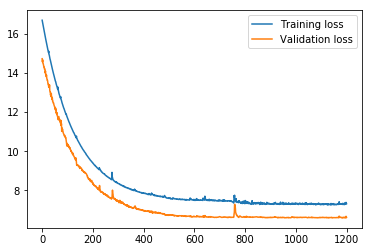

In [19]:
start_time = time.time()

history=model.fit(X_train,y_train,batch_size=32,epochs=800,validation_split=0.1)

training_time=round(time.time() - start_time,2)
print("\nTraining time :'--- %s min %s sec ---" % (training_time//60,training_time%60) )

loss = history.history['loss']
val_loss= history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.show()

In [20]:
pred=model.predict(X_test)
print(X_test.shape)
print(pred.shape)

(15, 100, 100, 3)
(15, 17, 17, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


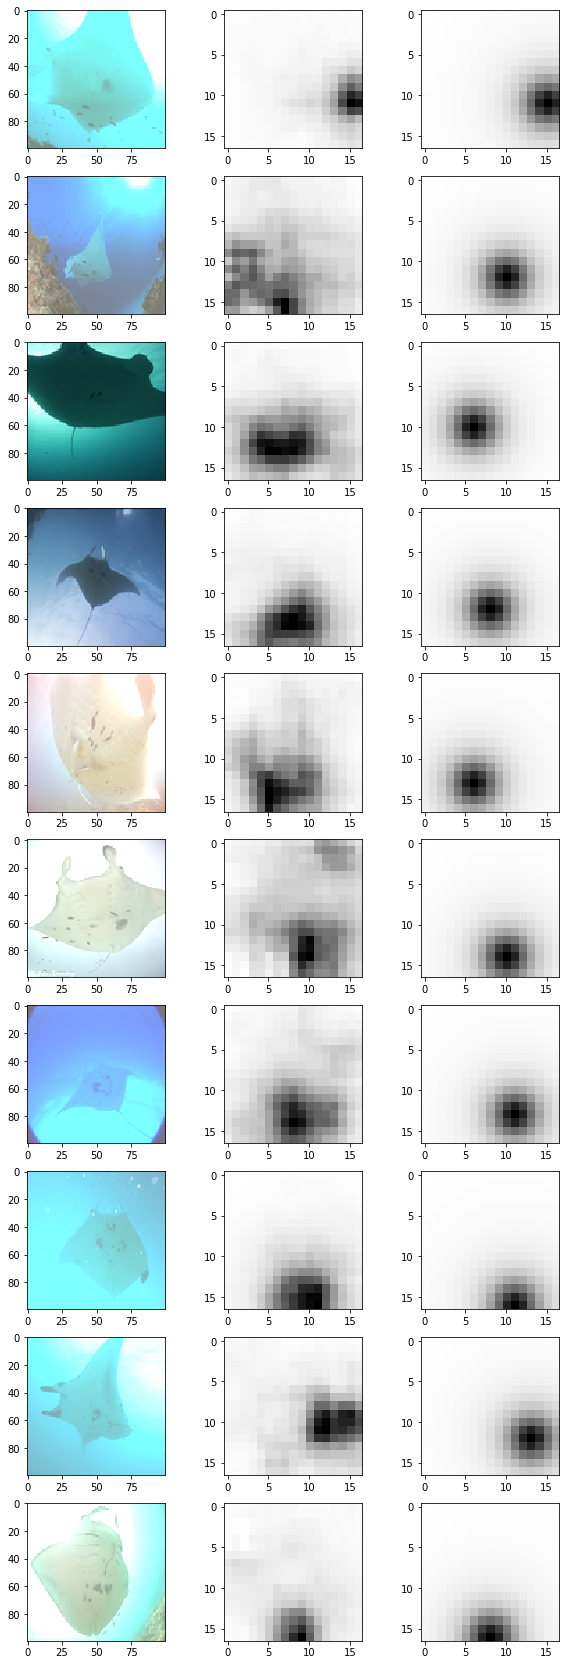

In [21]:
n=10#X_test.shape[0]
samples=random.sample(list(np.arange(pred.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=3,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X_test[s]))
    axes[i,1].imshow(pred[s][:,:,0],cmap='Greys')
    axes[i,2].imshow(y_test[s][:,:,0],cmap='Greys')
plt.show()

In [18]:
# large heatmap
# Распределение Коши  1/(1+((x-xo)/r)**2)
+ validation set
+ get rid of maxPooling layer?
+ augmentation
+ labelling


SyntaxError: invalid syntax (<ipython-input-18-3a9fb3823701>, line 3)